In [1]:
import re
import gensim
import logging
import pandas as pd
import urllib.request
from gensim.models import word2vec

In [7]:
import networkx as nx

In [2]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", 
                           "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x1fc43139048>)

In [3]:
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

In [125]:
words = ['лингвистика_S']

def get_neighbors(words, model):
    vertices = []
    relations = []
    for word in words:
        if word in model:
            for i in model.most_similar(positive=[word], topn = 100):
                # слово + коэффициент косинусной близости
                if i[1] >= 0.5:
                    if "_S" in i[0]:
                        vertices.append(i[0])
                        rel = [word, i[0], i[1]]
                        relations.append(rel)
        else:
            print('Слова "%s" нет в модели!' % word)
    return vertices, relations

vertices, relations = get_neighbors(words, model)

In [126]:
G = nx.Graph() # пустой граф

def update_graph(G, vertices, relations):
    G.add_nodes_from(vertices)
    for rel in relations:
        G.add_edge(rel[0], rel[1], weight=rel[2])
        
update_graph(G, vertices, relations)
nx.write_gexf(G, 'graph_file.gexf')

In [127]:
# One circle more
vertices, relations = get_neighbors(vertices, model)
update_graph(G, vertices, relations)

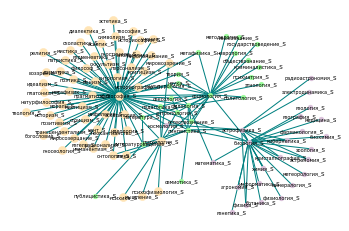

[['агрономия_S', 'астрономия_S', 'астрофизика_S', 'биология_S', 'биохимия_S', 'ботаника_S', 'генетика_S', 'география_S', 'геология_S', 'зоология_S', 'информатика_S', 'кибернетика_S', 'космология_S', 'кристаллография_S', 'математика_S', 'медицина_S', 'метеорология_S', 'минералогия_S', 'радиоастрономия_S', 'фармакология_S', 'физика_S', 'физиология_S', 'химия_S', 'электродинамика_S'], ['антропология_S', 'государствоведение_S', 'естествознание_S', 'криминалистика_S', 'культурология_S', 'лингвистика_S', 'литература_S', 'литературоведение_S', 'метафизика_S', 'методология_S', 'наука_S', 'неврология_S', 'обществознание_S', 'педагогика_S', 'политология_S', 'психиатрия_S', 'публицистика_S', 'сексология_S', 'семиотика_S', 'социология_S', 'теория_S', 'филология_S', 'этнология_S', 'языкознание_S'], ['апологетика_S', 'аскетик_S', 'богословие_S', 'воззрение_S', 'гегель_S', 'герменевтика_S', 'гносеология_S', 'гностицизм_S', 'диалектика_S', 'догматика_S', 'идеализм_S', 'идеология_S', 'имманентизм_S', '

In [128]:
import matplotlib.pyplot as plt
from matplotlib import style
from networkx.algorithms import community
import random
colors = ['thistle', 'palegreen', 'moccasin', 'indigo', 'pink', 'sienna', 'olive', 'tomato', 'seagreen', 'skyblue']
i = 0
style.use('ggplot') 
%matplotlib inline
d = dict(G.degree)
pos=nx.kamada_kawai_layout(G)
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
comms = sorted(map(sorted, next_level_communities))
for c in comms:
    for j in c:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=c, node_color=colors[i%10], node_size=d.get(j))
    i += 1
nx.draw_networkx_edges(G, pos, edge_color='teal')
nx.draw_networkx_labels(G, pos, font_size=5, font_color = 'black', font_family='Verdana')
plt.axis('off') 
plt.show()
print(comms)

In [ ]:
Указание:
    цвет определяет сообщество, размер определяет централизованность сообщества по degree centrality.
Интерпретация сообществ:
    1 (правое, сиреневое) - типичные "hard studies", естественные науки.
    2 (середина, зелёное) - "soft studies", социальные, гуманитарные науки.
    3 (левое, персиковое) - учения, воззрения, области, связанные с интерпретацией реальности.

In [129]:
# Центральность узлов, топ-3

deg = nx.degree_centrality(G)
print("degree_centrality: ", sorted(deg, key=deg.get, reverse=True)[:3])

clos = nx.closeness_centrality(G)
print("closeness_centrality: ", sorted(deg, key=clos.get, reverse=True)[:3])

betw = nx.betweenness_centrality(G)
print("betweenness_centrality: ", sorted(deg, key=betw.get, reverse=True)[:3])

eig = nx.eigenvector_centrality(G)
print("eigencentrality: ", sorted(deg, key=eig.get, reverse=True)[:3])

degree_centrality:  ['философия_S', 'биология_S', 'социология_S']
closeness_centrality:  ['философия_S', 'социология_S', 'лингвистика_S']
betweenness_centrality:  ['философия_S', 'биология_S', 'социология_S']
eigencentrality:  ['философия_S', 'социология_S', 'психология_S']


In [130]:
# Радиус графа, минимальный эксцентриситет среди всех вершин графа
print(nx.radius(G))

# Диаметр графа, самый длинный путь от одной вершины до другой
print(nx.diameter(G))

# Коэффициент ассортативности (насколько вся сеть завязана на основных "хабах"):
print(nx.degree_pearson_correlation_coefficient(G))

# Плотность графа, отношение рёбер и узлов
print(nx.density(G))

# Кластеризация
print(nx.average_clustering(G))

2
4
-0.5517277105895944
0.025765496639283045
0.17994945179309726
